# Evaluate strategies over multiple endpoints using boxplots

This notebook illustrates, how the predictions could be evaluated using boxplots.

For each endpoints, ACP's are trained both 'with and without normaliser model' and 'with and without updating the calibration set'. In this example, the calibration set is even updated twice. 

For comparison over all endpoints, the rmsd to the diagonal line in the calibration plot (significance level) is calculated. Here, the rmsd over all compounds is calculated, alternatively, we could also calculate it class-wise.

In [1]:
import pandas as pd
import numpy as np
import sys
import math

In [2]:
import matplotlib.pyplot as plt

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsRegressor

In [4]:
from nonconformist.nc import InverseProbabilityErrFunc, NcFactory

In [5]:
# Define path to import script(s) from
scripts_path = "../scripts/"
sys.path.append(scripts_path)

In [6]:
from continuous_calibration import (
StratifiedRatioSampler, BalancedStratifiedRatioSampler, CrossValidationSampler, InductiveConformalPredictor, 
    ContinuousCalibrationAggregatedConformalPredictor, CrossValidator
)

### Define paths and parameters

In [7]:
data_path = "../data/DesFin_pvalues_complete.csv" # File in Tresorit

In [8]:
endpoints = ["Toxicity_CHR_Lung_InVivo", "Toxicity_CHR_Adrenal Gland_InVivo", 
             "Toxicity_CHR_Bone Marrow_InVivo", "Toxicity_DILI_Combined_InVivo"]

In [9]:
ntrees = 100

n_folds_acp = 3 # 20

In [10]:
def load_data_per_endpoint(data_path, endpoint):
    data = pd.read_csv(data_path, header=0, index_col=0)
    data = data[data[endpoint] != -1]
#     print(data.columns)
    y = data[endpoint].values
    columns = [col for col in data.columns if col.startswith('p') or col.startswith('byte')]
    X = data[columns].values
    return X, y

In [11]:
def prepare_rf_acp(normaliser_model):
    clf = RandomForestClassifier(n_estimators=ntrees)
    error_function = InverseProbabilityErrFunc()
    nc = NcFactory.create_nc(clf, err_func=error_function, normalizer_model=normaliser_model)
    icp = InductiveConformalPredictor(nc_function=nc, condition=(lambda instance: instance[1]), 
                                      smoothing=False)
    if normaliser_model:
        ratio_sampler = BalancedStratifiedRatioSampler(n_folds=n_folds_acp)
    else:
        ratio_sampler = StratifiedRatioSampler(n_folds=n_folds_acp)
    acp = ContinuousCalibrationAggregatedConformalPredictor(
        predictor=icp, sampler=ratio_sampler, aggregation_func=np.median)
    return acp

In [12]:
def calculate_deviation_square(error, sl):
    return (error-sl)**2

In [13]:
def calculate_rmsd_from_df(eval_df, cl=None):
    if cl:
        eval_df['square'] = eval_df.apply(lambda row: calculate_deviation_square(
            row[f"error_rate_{cl} mean"],   row["significance_level"]), axis=1)
    else:
        eval_df['square'] = eval_df.apply(lambda row: calculate_deviation_square(
            row["error_rate mean"], row["significance_level"]), axis=1)
    rmsd = np.round(math.sqrt(np.mean(eval_df["square"])), 3)
    return rmsd

### Run experiment (train different acps, calibrate, and predict) for all endpoints

In [ ]:
evaluation_dfs = {"cv_original": [], "cv_normalise": [], 'original': [], 
                  'normalise': [], 'normalise_update1': [], 'update1': [],
                  'normalise_update2': [], 'update2': []}
for endpoint in endpoints:
    print(endpoint)
    # Prepare data
    X, y = load_data_per_endpoint(data_path, endpoint)
    X_train, X_update1, X_update2, X_score = np.split(X, [200, 300, 400])
    y_train, y_update1, y_update2, y_score = np.split(y, [200, 300, 400])
    print(y_train.sum(), y_update1.sum(), y_update2.sum(), y_score.sum())
    for normaliser_model in [None, KNeighborsRegressor()]:
        # Define ACP and crossvalidator
        acp = prepare_rf_acp(normaliser_model)
        cross_validator = CrossValidator(predictor=acp, cv_splitter=CrossValidationSampler())
        # Crossvalidate using 'original' calibration set
        cross_validator.cross_validate(
            X_train=X_train, y_train=y_train, X_score=X_score, y_score=y_score,
            steps=10, endpoint=endpoint
        )
        # Update calibration set within above crossvalidation loop
        cross_validator.cross_validate_calibrate_update(
            X_update=X_update1, y_update=y_update1, X_score=X_score, y_score=y_score, 
            steps=10, endpoint=endpoint
        )
        # Update calibration set again within above crossvalidation loop
        cross_validator.cross_validate_calibrate_update(
            X_update=X_update2, y_update=y_update2, X_score=X_score, y_score=y_score, 
            steps=10, endpoint=endpoint
        )
        # Store dataframes with evaluation values
        # fixme: We could even save the calibration plots within this loop
        if normaliser_model is None:
            evaluation_dfs["original"].append(cross_validator.averaged_evaluation_df_pred_score)
            evaluation_dfs["cv_original"].append(cross_validator.averaged_evaluation_df_cv)
            evaluation_dfs["update1"].append(cross_validator.averaged_evaluation_df_cal_update_1)
            evaluation_dfs["update2"].append(cross_validator.averaged_evaluation_df_cal_update_2)
        else:
            evaluation_dfs["normalise"].append(cross_validator.averaged_evaluation_df_pred_score)
            evaluation_dfs["cv_normalise"].append(cross_validator.averaged_evaluation_df_cv)
            evaluation_dfs["normalise_update1"].append(cross_validator.averaged_evaluation_df_cal_update_1)
            evaluation_dfs["normalise_update2"].append(cross_validator.averaged_evaluation_df_cal_update_2)
            

Toxicity_CHR_Lung_InVivo
73 24 37 32
fold:  0
fold:  1
fold:  2
fold:  3
fold:  4
fold:  0
final n:  1
updated_number:  1
fold:  1
final n:  1
updated_number:  1
fold:  2
final n:  1
updated_number:  1
fold:  3
final n:  1
updated_number:  1
fold:  4
final n:  1
updated_number:  1
fold:  0
n 1
final n:  2
updated_number:  2
fold:  1
n 1
final n:  2
updated_number:  2
fold:  2
n 1
final n:  2
updated_number:  2
fold:  3
n 1
final n:  2
updated_number:  2
fold:  4
n 1
final n:  2
updated_number:  2
fold:  0
fold:  1
fold:  2
fold:  3
fold:  4
fold:  0
final n:  1
updated_number:  1
fold:  1
final n:  1
updated_number:  1
fold:  2
final n:  1
updated_number:  1
fold:  3
final n:  1
updated_number:  1
fold:  4
final n:  1
updated_number:  1
fold:  0
n 1
final n:  2
updated_number:  2
fold:  1
n 1
final n:  2
updated_number:  2
fold:  2
n 1
final n:  2
updated_number:  2
fold:  3
n 1
final n:  2
updated_number:  2
fold:  4
n 1
final n:  2
updated_number:  2
Toxicity_CHR_Adrenal Gland_InVivo

### Calculate rmsd's for all endpoints over all strategies

In [15]:
rmsds = {}
for k, v in evaluation_dfs.items():
    rmsds[k] = []
    for df in v:
        rmsd = calculate_rmsd_from_df(df)
        rmsds[k].append(rmsd)
rmsds

{'cv_original': [0.05, 0.051, 0.044, 0.027],
 'cv_normalise': [0.105, 0.041, 0.126, 0.053],
 'original': [0.081, 0.041, 0.104, 0.077],
 'normalise': [0.094, 0.077, 0.093, 0.058],
 'normalise_update1': [0.051, 0.055, 0.059, 0.024],
 'update1': [0.054, 0.032, 0.033, 0.061],
 'normalise_update2': [0.07, 0.059, 0.061, 0.037],
 'update2': [0.064, 0.035, 0.055, 0.028]}

### Plot boxplot

In [16]:
strategies = ["cv_original", "cv_normalise", "original", "normalise", "update1", "update2", "normalise_update1", "normalise_update2"]

Text(0.5, 1.0, 'rmsd over all endpoints')

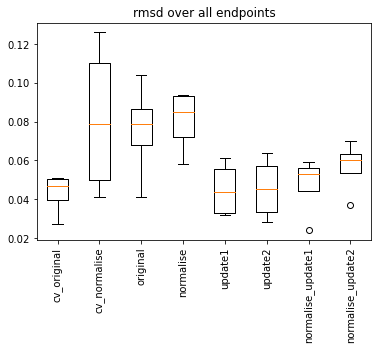

In [17]:
plt.boxplot([rmsds[k] for k in strategies], labels=strategies)
plt.xticks(rotation='vertical')
plt.title("rmsd over all endpoints")